# Credit Risk 

Pedro Henrique Rezende Oliveira

Imports

In [1]:
from matplotlib.gridspec import GridSpec
from matplotlib import cm

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            precision_recall_curve, f1_score, confusion_matrix, roc_curve, \
                            roc_auc_score

from IPython.display import HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from library import *
%matplotlib inline

## Reading the data

In [2]:
data = pd.read_csv('RETAIL_STUDENTS_FINAL.csv', index_col=0, parse_dates=True)

In [8]:
def keep_the_first_default(data):
    """
    Keep the first default in the data set
    """
    data_modele = data.loc[(data.MODELE == 3) + (data.MODELE == 4)]
    col = ['ID', 'RATING','ANCIENNETE', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
           'CIBLE']
    df_modele = data_modele.loc[:,col].sort_index()
    df = pd.DataFrame(columns = col)
    for i, df_g in df_modele.groupby('ID'):
        keep = (df_g.duplicated() == False)
        df_g = df_g.loc[keep]
        num = []
        controller = 0
        for j in range(df_g.shape[0]):
            if df_g.CIBLE[j] == 1:
                if controller == 0:
                    num.append(j)
                controller = 1
            else:
                num.append(j)
                controller = 0
        df_g = df_g.iloc[num,:]
        df_g.fillna(df_g.mean(), inplace=True)
        df_g.CIBLE = df_g.CIBLE.shift(1)
        df = df.append(df_g.iloc[1:])

    return df

In [9]:
df = keep_the_first_default(data) #keep only the firsts default dates.

In [19]:
df.columns = [col.replace(' ', '_').lower() for col in df.columns]
df.cible.replace([0,1],['good', 'bad'], inplace=True)
df.drop(columns="id", inplace=True)

KeyError: "['id'] not found in axis"

In [24]:
data = pd.read_csv('datatransformed.csv', index_col=0, parse_dates=True)
df.head(10)

,rating,anciennete,v1,v2,v3,v4,v5,v6,v7,v8,cible
2008-02-28,False,False,False,False,False,False,False,False,False,False,False
2008-03-30,False,False,False,False,False,False,False,False,False,False,False
2008-04-30,False,False,False,False,False,False,False,False,False,False,False
2008-05-31,False,False,False,False,False,False,False,False,False,False,False
2008-06-29,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2008-05-31,False,False,False,False,False,False,False,False,False,False,False
2008-06-29,False,False,False,False,False,False,False,False,False,False,False
2008-07-31,False,False,False,False,False,False,False,False,False,False,False
2008-11-30,False,False,False,False,False,False,False,False,False,False,False


In [14]:
# df.to_csv(r'datatransformed.csv', index=True) 

In [16]:
#so we get the distribution of the columns with missing data, we fill the missing data so to keep the distr!!!!
columns_with_missing_data = df.columns[df.isnull().sum() != 0]
for variable in columns_with_missing_data:
    d = df[variable].value_counts(normalize=True)
    missing = df[variable].isnull()
    df.loc[missing,variable] = np.random.choice(d.index, size=len(df[missing]),p=d.values)


# Null data
df.isnull().sum()

1.000000    0.904298
2.000000    0.085993
3.000000    0.007372
4.000000    0.000674
1.500000    0.000315
1.333333    0.000306
5.000000    0.000175
1.250000    0.000131
1.666667    0.000131
1.750000    0.000079
1.200000    0.000070
1.600000    0.000070
1.400000    0.000061
1.800000    0.000053
1.833333    0.000044
1.166667    0.000044
1.285714    0.000026
1.125000    0.000026
2.333333    0.000026
2.400000    0.000026
1.142857    0.000018
4.500000    0.000018
1.714286    0.000009
1.625000    0.000009
1.428571    0.000009
1.555556    0.000009
1.875000    0.000009
Name: v8, dtype: float64

In [25]:
# Detailed information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713695 entries, 2008-02-28 to 2008-12-31
Data columns (total 11 columns):
rating        713695 non-null object
anciennete    713695 non-null float64
v1            713695 non-null float64
v2            713695 non-null float64
v3            713695 non-null float64
v4            713695 non-null float64
v5            713695 non-null float64
v6            713695 non-null float64
v7            713695 non-null float64
v8            713695 non-null float64
cible         713695 non-null object
dtypes: float64(9), object(2)
memory usage: 65.3+ MB


In [26]:
# Describing statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
anciennete,713695.0,5275.704045,3745.441158,1.000000e+00,1840.000000,4554.000000,8074.000000,1.168700e+04
v1,713695.0,17594.510190,6207.951780,3.500000e+01,13378.000000,17284.000000,21373.000000,4.346300e+04
v2,713695.0,20.109487,42.940474,1.000000e+00,4.000000,11.000000,22.000000,2.247000e+03
v3,713695.0,-0.048457,295.822705,-1.926659e+05,0.000000,0.000000,0.000000,6.540141e+04
v4,713695.0,32185.583797,296904.164402,-9.884304e+06,741.093262,3950.765257,18992.781417,6.258653e+07
v5,713695.0,0.967940,170.598378,-1.804850e+04,0.000000,0.000000,0.025493,1.174759e+05
v6,713695.0,7.291176,2775.740880,-1.222224e+06,0.141183,0.717979,3.021684,4.070487e+05
v7,713695.0,14.267850,28.114671,0.000000e+00,0.000000,0.000000,13.259733,2.000000e+02
v8,713695.0,1.104307,0.337460,1.000000e+00,1.000000,1.000000,1.000000,5.000000e+00


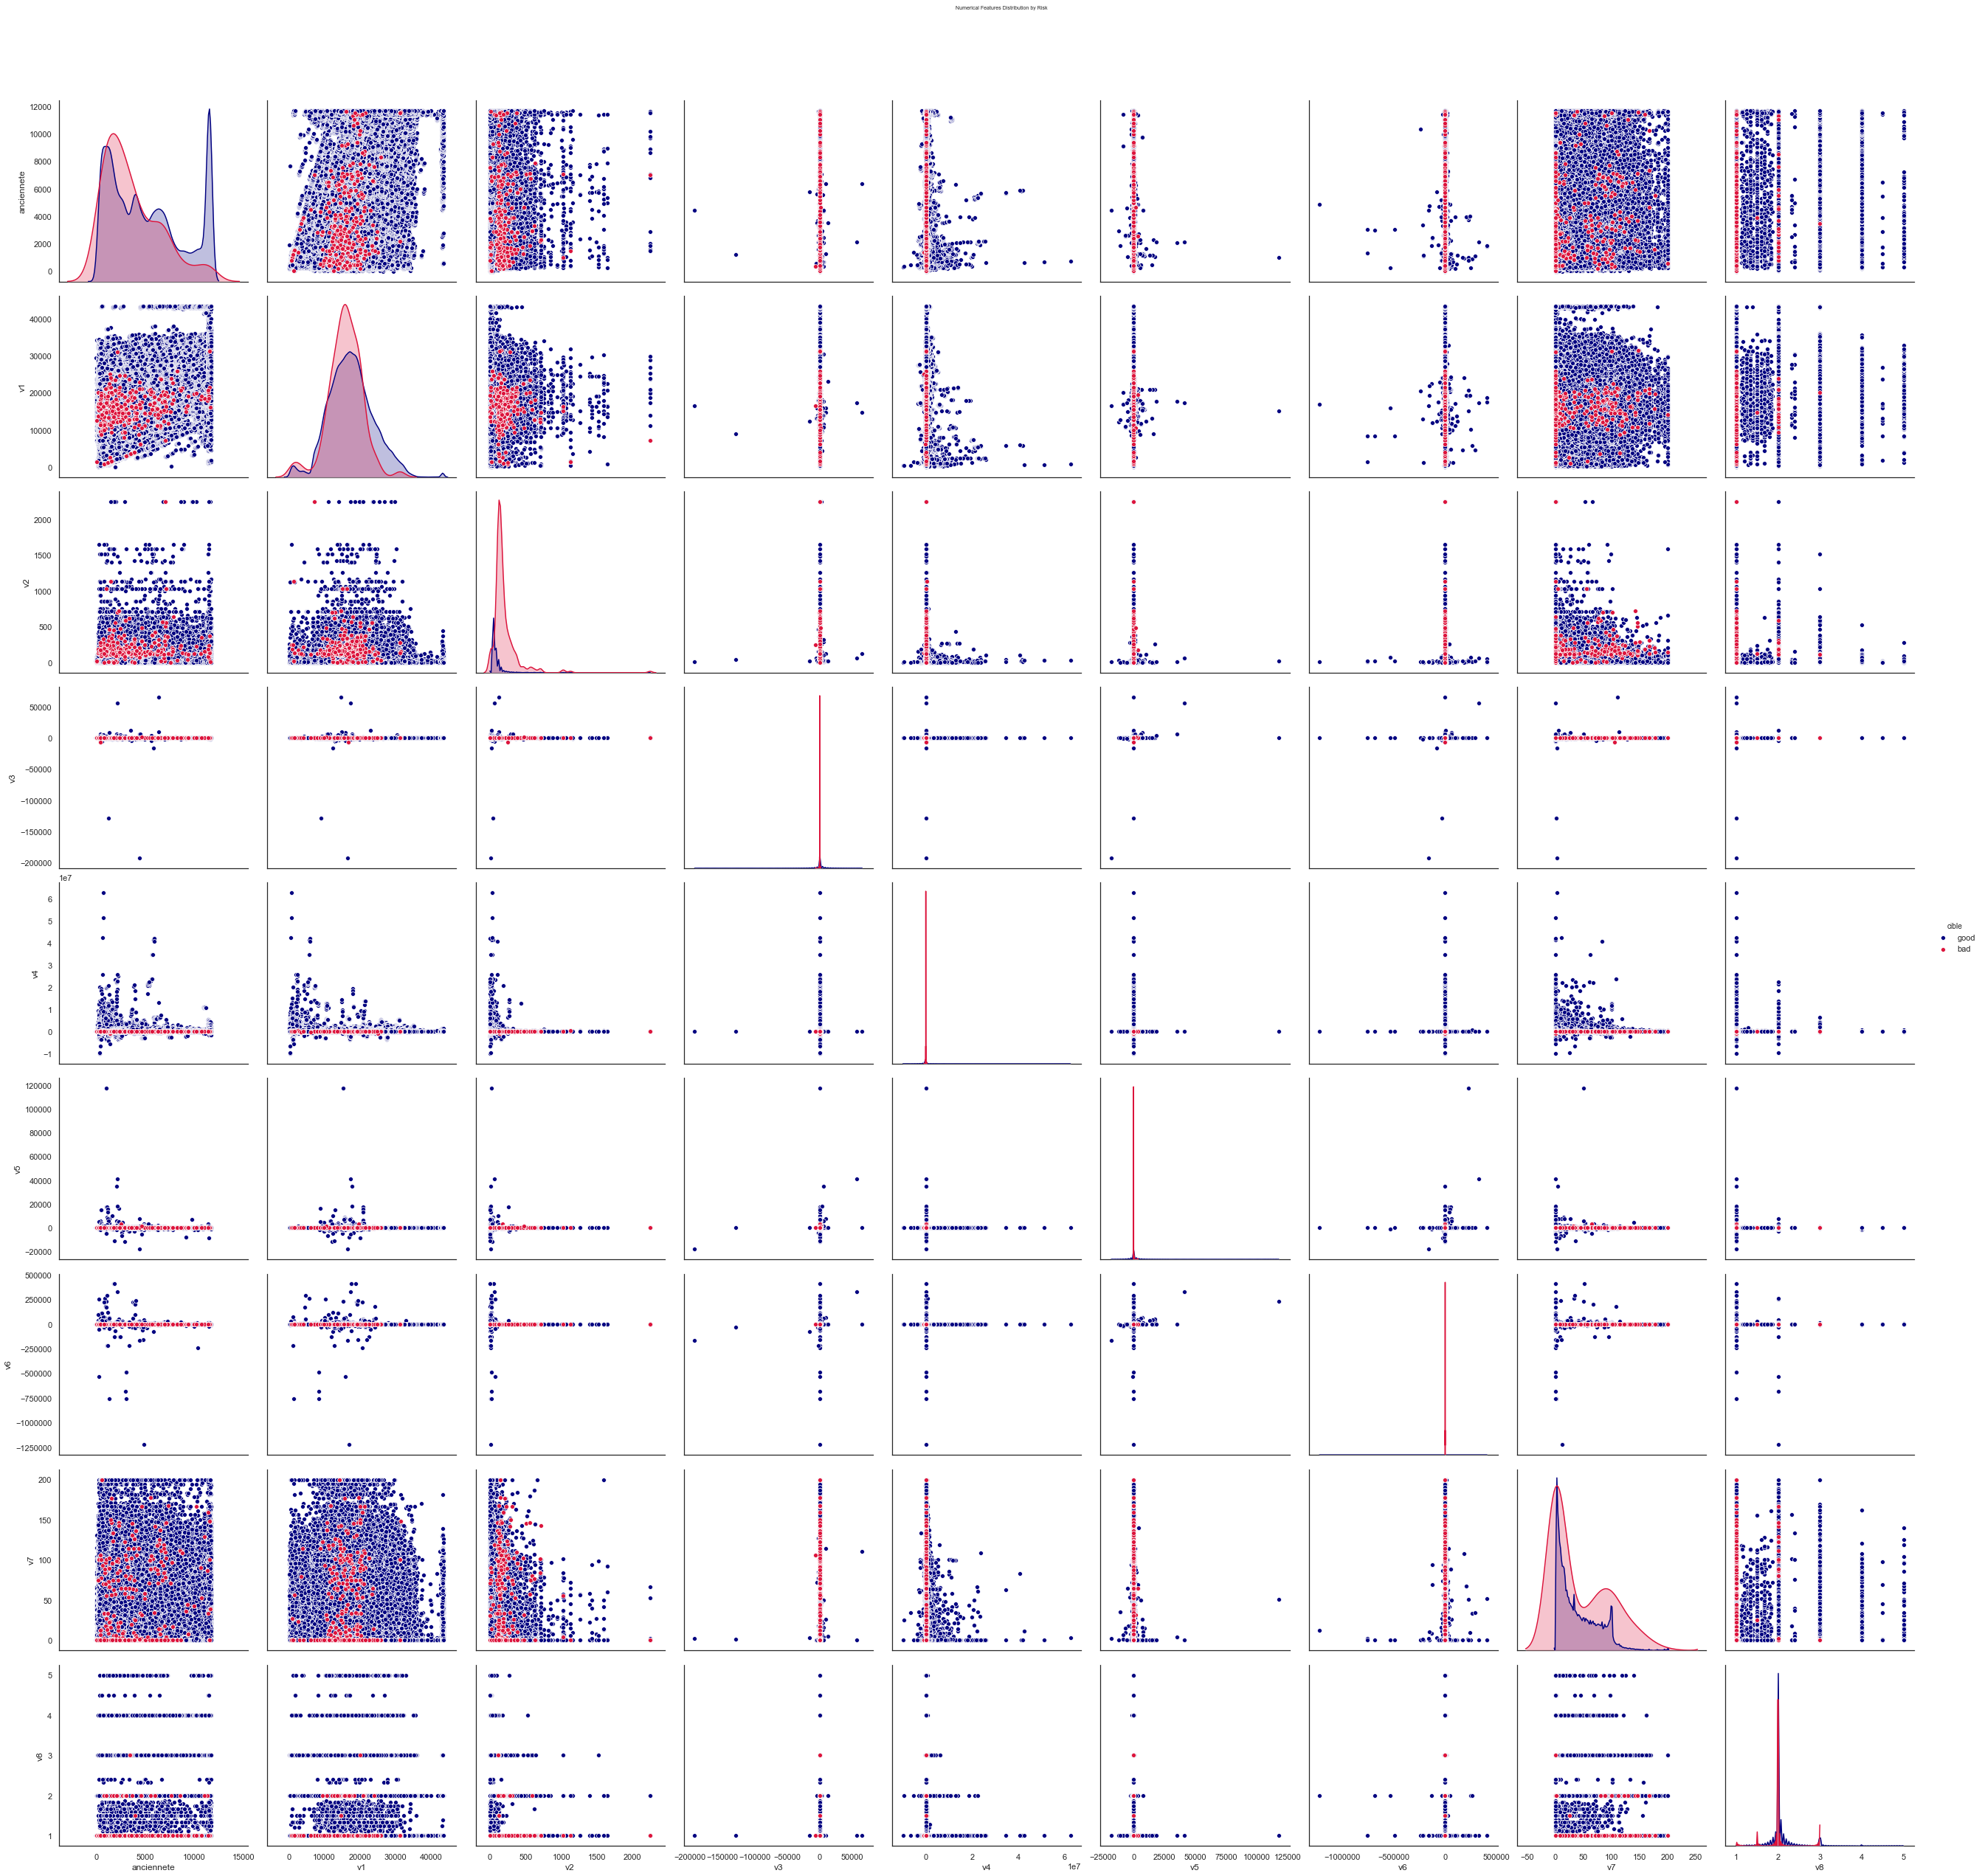

In [70]:
cols_pairplot_analyis = df.columns[[1,2,3,4,5,6,7,8,9,-1]]
df_pairplot = df.loc[:, cols_pairplot_analyis]
custom_colors = ["navy", "crimson"]
ax = sns.pairplot(data=df_pairplot, hue=df.columns[-1], palette=custom_colors, height=4);
fig = ax.fig
fig.suptitle('Numerical Features Distribution by Risk', size=7)
plt.subplots_adjust(top=.93)
plt.show()

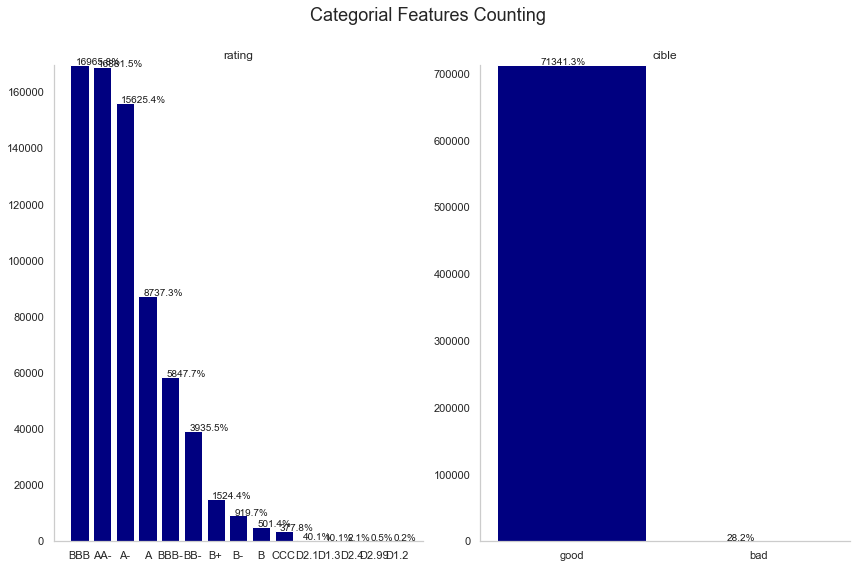

In [67]:

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
cols_cat = ['rating', df.columns[-1]]
categorical_plot(cols_cat, axs, df=df)
plt.tight_layout()
fig.suptitle('Categorial Features Counting', size=18)
plt.subplots_adjust(top=.88)

#fig, ax = plt.subplots(figsize=(7, 7))
#donut_plot('cible', df=df, text=f'Total: \n{str(len(df))} samples', ax=ax)
#ax.set_title('Risk Counting', size=14)
#plt.show()

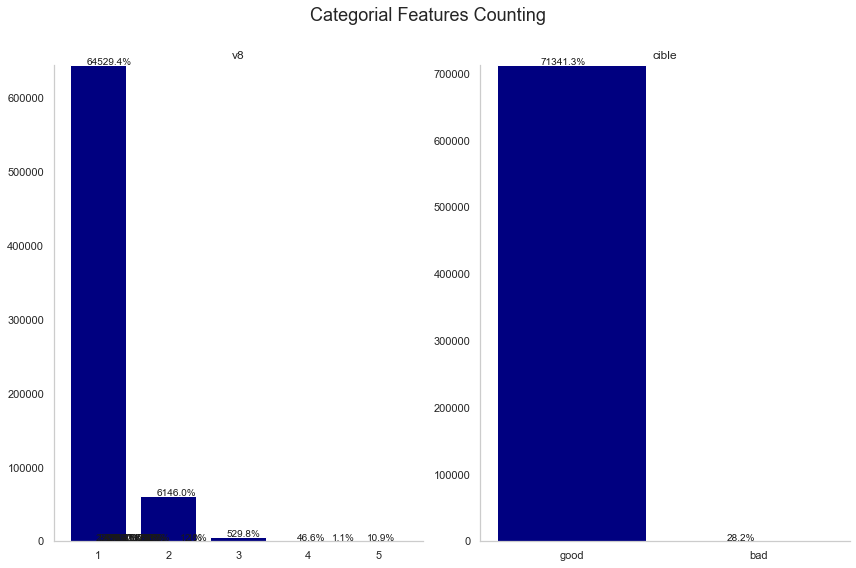

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
cols_cat = ['v8', df.columns[-1]]
categorical_plot(cols_cat, axs, df=df)
plt.tight_layout()
fig.suptitle('Categorial Features Counting', size=18)
plt.subplots_adjust(top=.88)
plt.show()

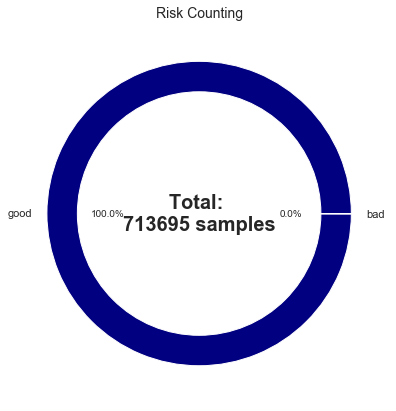

In [65]:
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot('cible', df=df, text=f'Total: \n{str(len(df))} samples', ax=ax)
ax.set_title('Risk Counting', size=14)
plt.show()

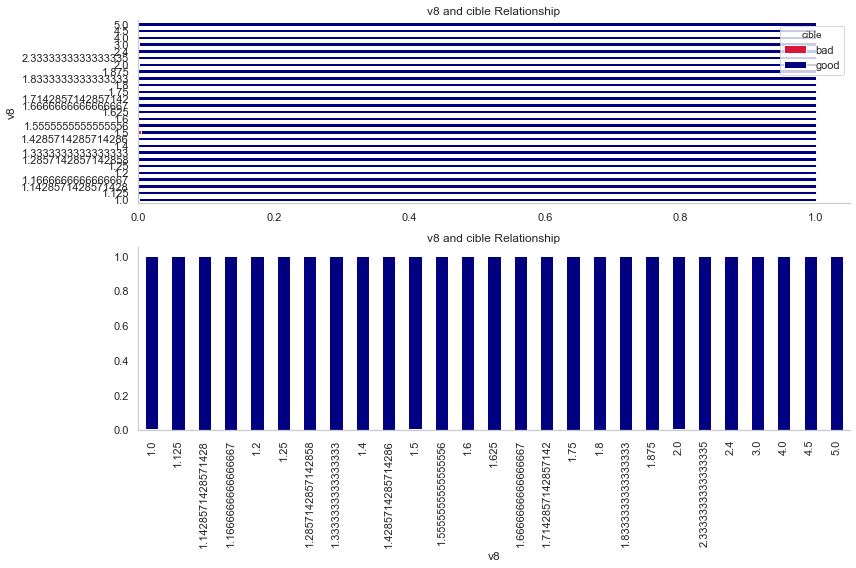

In [45]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, width_ratios=[10,10], height_ratios=[2, 2])

# Configuring grid spec axis
ax1 = fig.add_subplot(gs[0, :])

# v8 by cible laybar
v8_to_cible = pd.crosstab(df['v8'], df['cible'])
v8_to_cible.div(v8_to_cible.sum(1).astype(float), axis=0).plot(kind='barh',
                                                                      stacked=True, ax=ax1,
                                                                      colors=['crimson', 'navy'])
format_spines(ax1, right_border=False)
ax1.set_title('v8 and cible Relationship')

## Configuring grid spec axis
ax2 = fig.add_subplot(gs[1, :])

# v9 by cible upbar
v8_to_cible = pd.crosstab(df['v8'], df['cible'])
v8_to_cible.div(v8_to_cible.sum(1).astype(float), axis=0).plot(kind='bar',
                                                                       stacked=True, ax=ax2,
                                                                       colors=['crimson', 'navy'], legend=None)
format_spines(ax2, right_border=False)
ax2.set_title('v8 and cible Relationship')
#for tick in ax3.get_xticklabels():
#    tick.set_rotation(0)

fig.align_labels()
plt.tight_layout()
plt.show()

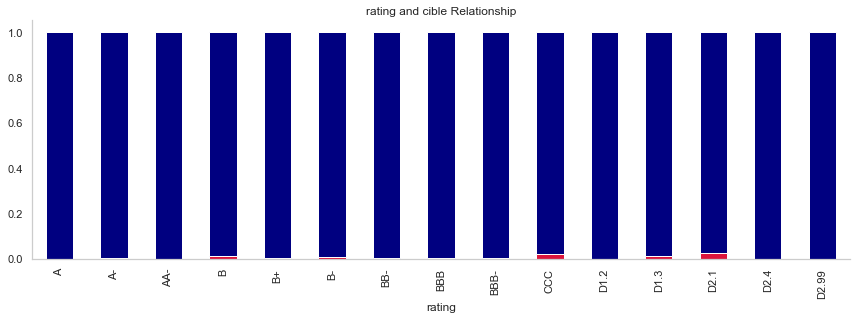

In [48]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, width_ratios=[10,10], height_ratios=[2, 2])

# Configuring grid spec axis
#ax1 = fig.add_subplot(gs[0, :])

## v8 by cible laybar
#rating_to_cible = pd.crosstab(df['rating'], df['cible'])
#rating_to_cible.div(v8_to_cible.sum(1).astype(float), axis=0).plot(kind='barh',
#                                                                      stacked=True, ax=ax1,
#                                                                      colors=['crimson', 'navy'])
#format_spines(ax1, right_border=False)
#ax1.set_title('Rating and cible Relationship')

## Configuring grid spec axis
ax2 = fig.add_subplot(gs[1, :])
#
# rating by cible upbar
rating_to_cible = pd.crosstab(df['rating'], df['cible'])
rating_to_cible.div(rating_to_cible.sum(1).astype(float), axis=0).plot(kind='bar',
                                                                       stacked=True, ax=ax2,
                                                                       colors=['crimson', 'navy'], legend=None)
format_spines(ax2, right_border=False)
ax2.set_title('rating and cible Relationship')
#for tick in ax3.get_xticklabels():
#    tick.set_rotation(0)

fig.align_labels()
plt.tight_layout()
plt.show()

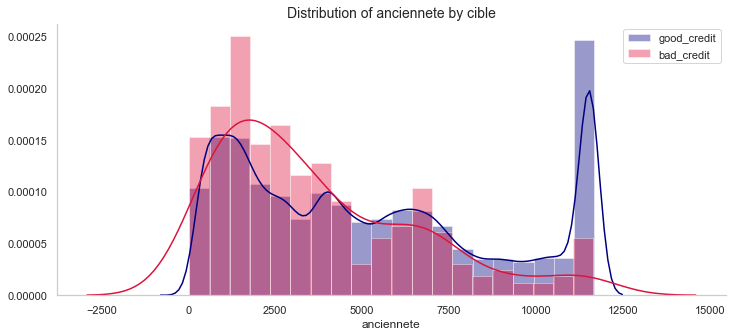

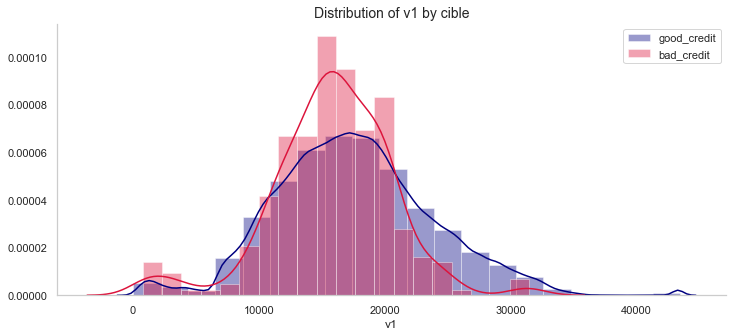

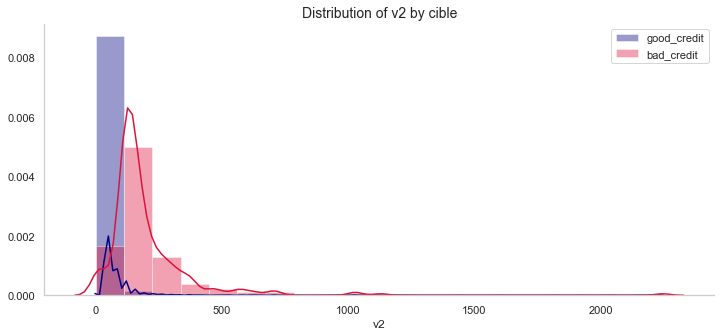

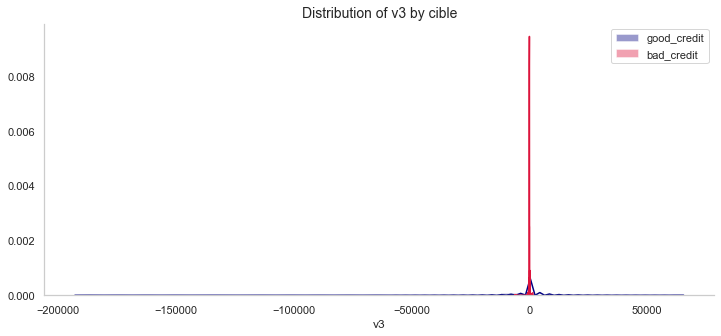

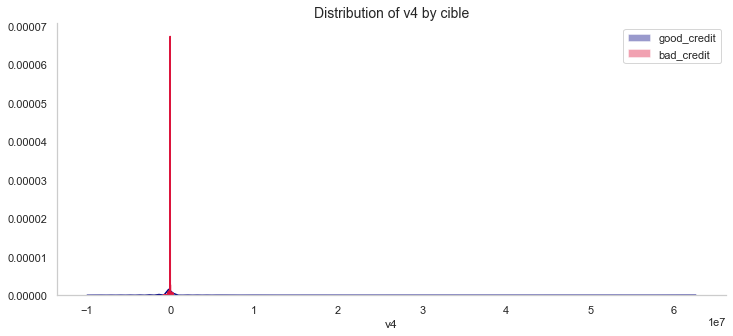

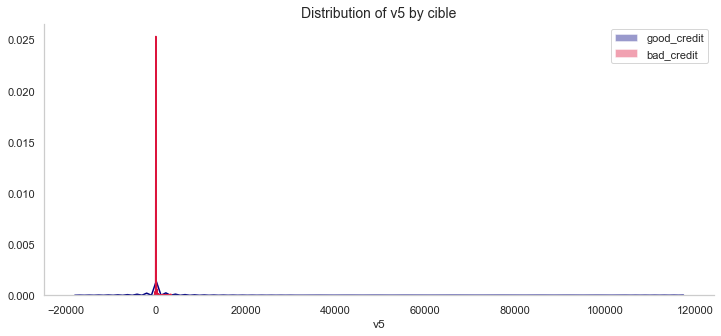

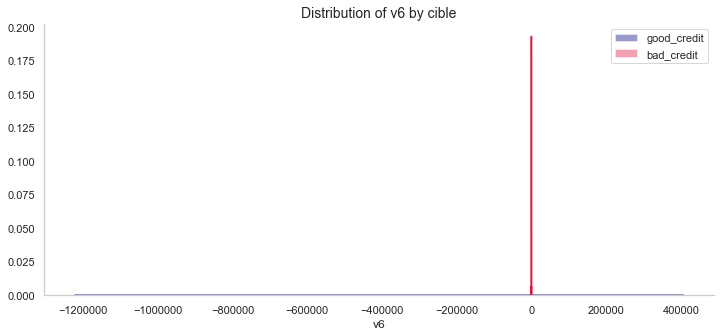

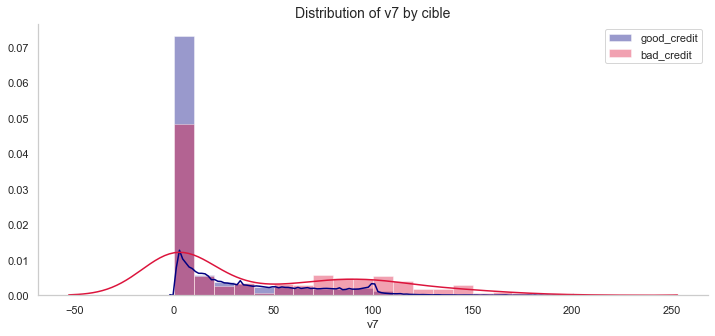

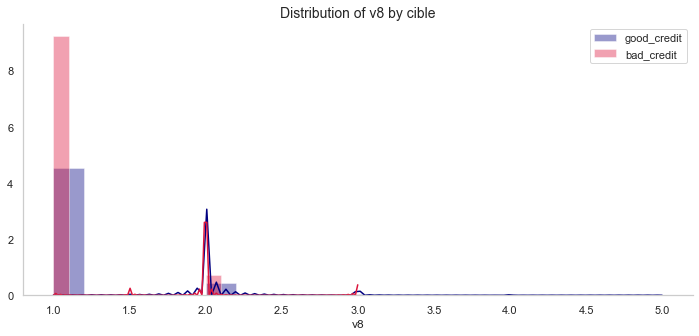

In [42]:
for i in df.columns[1:-1]:
    fig, ax = plt.subplots(figsize=(12, 5))
    risk_good = df.loc[df['cible'] == 'good']
    risk_bad = df.loc[df['cible'] == 'bad']
    ax = sns.distplot(risk_good[i], bins=20, label='good_credit', color='navy')
    ax = sns.distplot(risk_bad[i], bins=20, label='bad_credit', color='crimson')
    ax.set_title(f'Distribution of {i} by cible', size=14)
    ax.patch.set_facecolor('#FFFFFF')
    format_spines(ax, right_border=False)
    plt.legend()
    plt.show()